W tej części projektu zbudowane zostaną modele sieci neuronowych dla zadania segmentacji semantycznej dla zbioru [people-clothing-segmenation](/kaggle/input/people-clothing-segmentation)

# Wczytywanie i przygotowanie danych

In [1]:
install.packages("tfdatasets")
library(tfdatasets)
library(tidyverse)
library(tensorflow)
library(keras)
library(fields)
library(fs)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: spam

Spam version 2.9-1 (2022-08-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, for

In [2]:
images = "/kaggle/input/people-clothing-segmentation/png_images/IMAGES"
masks = "/kaggle/input/people-clothing-segmentation/png_masks/MASKS"

In [3]:
image_paths = tibble(input = dir_ls(images, glob = "*.png"),
       mask = dir_ls(masks, glob = "*.png"))

In [4]:
display_image_tensor <- function(x, ..., max = 255,
                                 plot_margins = c(0, 0, 0, 0)) {   
  if(!is.null(plot_margins))
    par(mar = plot_margins)
 
  x %>%
    as.array() %>%
    drop() %>% as.raster(max = max) %>% plot()
    
}

display_target_tensor <- function(x, plot_margins = c(0, 0, 0, 0)) {   
  if(!is.null(plot_margins))
    par(mar = plot_margins)
 
 x %>% as.array() %>%
    drop() %>% apply(., 2, rev) %>% t() %>% image.plot(breaks = 0:58, nlevel = 58, col = hcl.colors(n = 58, palette = "Fall"), yaxt = "n", xaxt = "n")
}

## Przygotowanie zbioru danych do uczenia
Wszystkie obrazy ze zbioru są rozmiaru (825px x 550px). Pomimo tego, że nie ma ich dużo (tylko 1000), aby zmniejszyć zapotrzebowanie na pamięć RAM, zostanie dokonana kompresja do rozmiaru (256px x 256px). Zabieg ten nie powinien wpłynąć na jakość dopasowania modeli, a spowoduje znaczne zaoszczędzenie zasobów.

In [5]:
tf_read_image <- function(path, format = "image", resize = NULL, ...) {
  img <- path %>%
    tf$io$read_file()  %>% 
    tf$io[[paste0("decode_", format)]](...)

  if (!is.null(resize)) {
    img <- img %>%
      tf$image$resize(as.integer(resize))
  }
  img
}

img_size <- c(256, 256)

tf_read_image_and_resize <- function(..., resize = img_size) {
  tf_read_image(..., resize = resize)
}

make_dataset <- function(paths_df) {
  tensor_slices_dataset(paths_df) %>% 
    dataset_map(function(path) {
      image <- path$input %>%
        tf_read_image_and_resize("png", channels = 3L)
      target <- path$mask %>% 
        tf_read_image_and_resize("png", channels = 1L)
      list(image, target)
    }) %>% 
    dataset_cache() %>% 
    dataset_shuffle(buffer_size = nrow(paths_df)) %>%
    dataset_batch(16)
}


Podział na zbiór treningowy, walidacyjny, uczący (700, 100, 200):

In [6]:
set.seed(2023)
train_idx = sample(1:nrow(image_paths), 800)

train_paths <- image_paths[train_idx, ]
test_paths <- image_paths[-train_idx, ]

set.seed(2023)
vali_paths = train_paths %>% sample_n(size = 100)
train_paths = setdiff(train_paths, vali_paths)

train_dataset <- make_dataset(train_paths)
vali_dataset <- make_dataset(vali_paths)
test_dataset <- make_dataset(test_paths)

Mając przygotowane zbiory, możemy wreszcie przystąpić do budowy architektury i uczenia sieci.

# Densenet121

Densenet121 jest jednym z modeli sieci neuronowych stosowanych w dziedzinie głębokiego uczenia się (deep learning). Jest to architektura sieci konwolucyjnych, która została zaproponowana przez badaczy z Microsoft Research w 2016 roku.

Densenet121 wyróżnia się unikalną strukturą połączeń między warstwami. W tradycyjnych sieciach neuronowych dane przepływają sekwencyjnie przez warstwy, a informacja musi przechodzić przez wszystkie warstwy od początku do końca. W przypadku Densenet121, każda warstwa otrzymuje jako wejście nie tylko dane z poprzedniej warstwy, ale także dane z wszystkich poprzednich warstw. To oznacza, że dane mają możliwość przepływania bezpośrednio między dowolnymi dwiema warstwami. 

Taka struktura połączeń nazywana jest "połączeniami gęstymi" (dense connections) i ma kilka zalet. Po pierwsze, umożliwia efektywniejsze wykorzystanie informacji poprzez przekazywanie jej bezpośrednio z niższych warstw do wyższych warstw. Po drugie, pomaga w redukcji zjawiska zanikającego gradientu (vanishing gradient problem), które może wystąpić podczas uczenia się głębokich sieci neuronowych. Połączenia gęste pomagają wzmocnić przepływ gradientów i przyspieszyć proces uczenia się.

Densenet121 jest konkretną wersją modelu DenseNet, która składa się z 121 warstw. Został wytrenowany na dużym zbiorze danych, takim jak ImageNet, i może być używany do różnych zadań związanych z widzeniem komputerowym, takich jak klasyfikacja obrazów, wykrywanie obiektów czy segmentacja obrazu. Jego zastosowanie może obejmować rozpoznawanie obrazów, analizę medyczną, analizę tekstu pisanego ręcznie i wiele innych.

In [7]:
baza = keras::application_densenet121(input_shape = c(256, 256, 3),
                                     include_top = FALSE,
                                     weights = "imagenet")

Sieć pomimo rozbudowanej struktury nie zawiera przerażającej liczby parametrów. Zobaczmy jak poradzi sobie z zadaniem przy odrmożonej całej architekturze.

In [8]:
summary(baza)

Model: "densenet121"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_1 (InputLayer)     [(None, 256, 256  0        []                         
                          , 3)]                                                 
                                                                                
 zero_padding2d (ZeroPadd  (None, 262, 262,  0       ['input_1[0][0]']          
 ing2D)                    3)                                                   
                                                                                
 conv1/conv (Conv2D)      (None, 128, 128,  9408     ['zero_padding2d[0][0]']   
                           64)                                                  
                                                                                
 conv1/bn (BatchNormaliza  (None, 128, 128,  256     ['conv1/conv[0][0]']       
 tion) 

In [9]:
dense_mod = keras_model_sequential() %>%
      baza %>%
      layer_conv_2d_transpose(filters = 32, kernel_size = 3, strides = 2, padding = "same") %>%
      layer_conv_2d_transpose(filters = 32, kernel_size = 3, strides = 2, padding = "same") %>%
      layer_batch_normalization() %>%
      layer_conv_2d_transpose(filters = 64, 3, strides = 2, padding = "same") %>%
      layer_conv_2d_transpose(filters = 128, kernel_size = 3, strides = 2, padding = "same") %>%
      layer_batch_normalization() %>%
      layer_conv_2d_transpose(filters = 256, 3, strides = 2, padding = "same") %>%
      layer_conv_2d(filters = 59, kernel_size = 3, activation = "softmax",padding = "same")
summary(dense_mod)

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 densenet121 (Functional)           (None, 8, 8, 1024)              7037504     
                                                                                
 conv2d_transpose_4 (Conv2DTranspos  (None, 16, 16, 32)             294944      
 e)                                                                             
                                                                                
 conv2d_transpose_3 (Conv2DTranspos  (None, 32, 32, 32)             9248        
 e)                                                                             
                                                                                
 batch_normalization_1 (BatchNormal  (None, 32, 32, 32)             128         
 ization)                                                                       
        

Uczenie przeprowadzone będzie wykorzystując optimizer `adam` z `learning_rate = 0.001` z funkcją straty `sparse_categorical_crossentropy`. Pomocne również będzie ustawienie pewnych callbacków.

In [10]:
opti = tf$keras$optimizers$Adam(learning_rate = 0.001)
callbacks <- list(
 callback_model_checkpoint("models/oxford_segmentation.keras",
                             save_best_only = TRUE), callback_early_stopping(patience = 5, monitor = "val_loss"))

In [11]:
dense_mod  %>%
 compile(optimizer = opti,
         loss = "sparse_categorical_crossentropy")

Niech uczenie trwa przez maksymalnie 50 epok.

In [12]:
history_dense <- dense_mod %>% fit(
 train_dataset,
 epochs = 50,
 callbacks = callbacks,
 validation_data = vali_dataset)

`geom_smooth()` using formula = 'y ~ x'


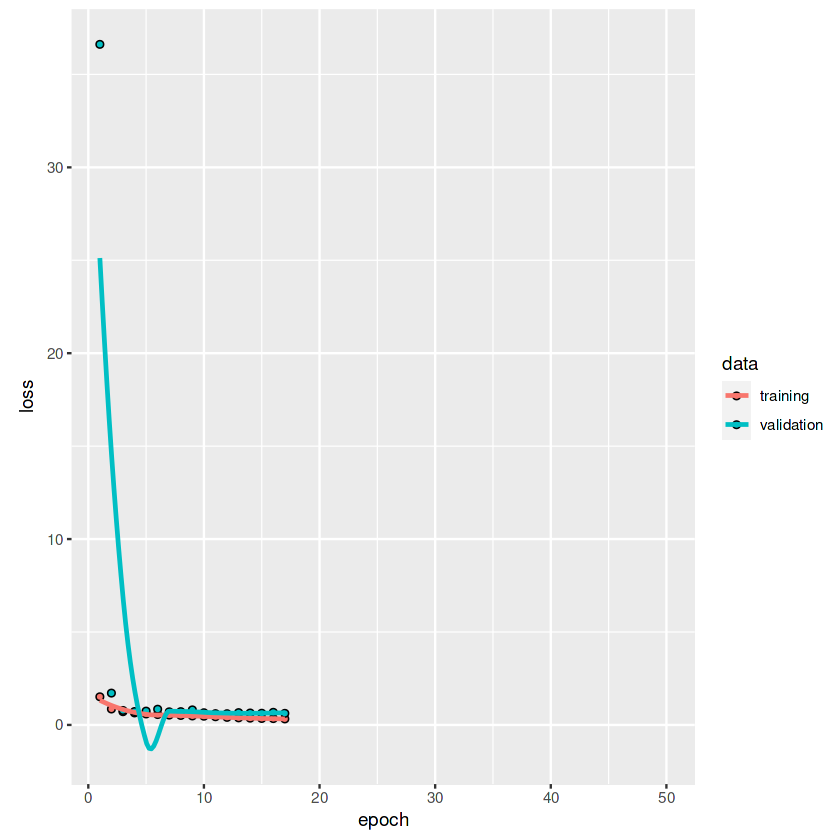

In [13]:
plot(history_dense)

Uczenie modelu przebiegło bez większych problemów. Strata na zbiorze walidacyjnym szybko się ustabilizowała i nie odbiega znacząco od straty na zbiorze treningowym. Uczenie szybko zostaje przerwane z powodu warunku na `patience = 5`

In [14]:
save_model_hdf5(dense_mod, filepath = "/kaggle/working/dense_mod.h5", include_optimizer = FALSE) # bo chce tylko architekture

Sprawdźmy na przykładowych obrazach ze zbioru walidacyjnego jak model oparty o architekturę `densenet121` radzi sobie z postawionym mu zadaniem.

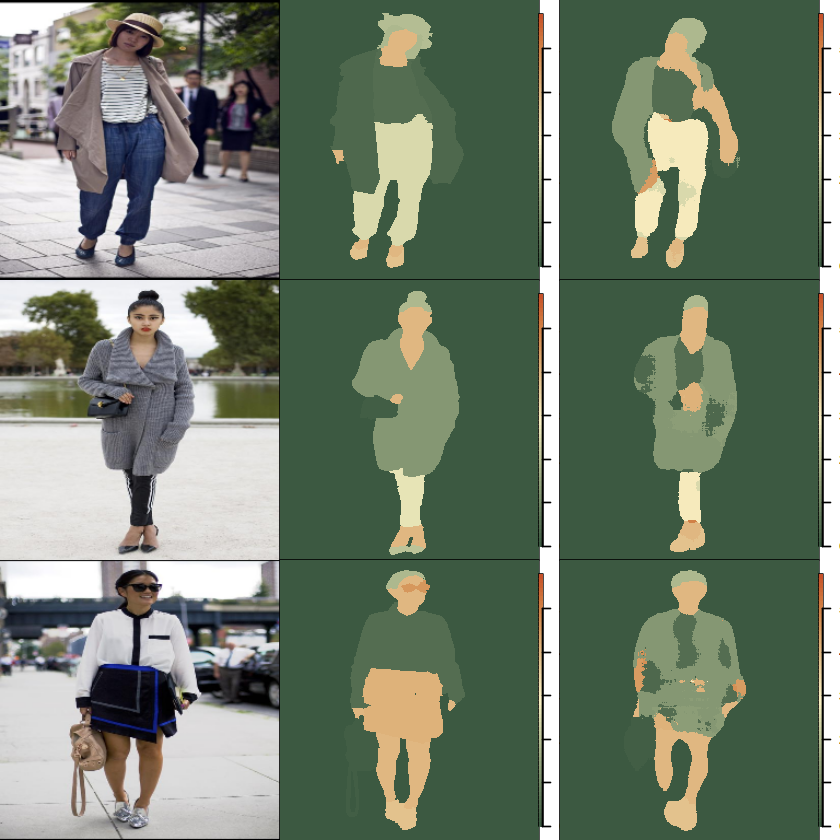

In [15]:
par(mfrow = c(3, 3))
test_image <- vali_paths$input[10] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- vali_paths$mask[10] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  dense_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

####################################
test_image <- vali_paths$input[21] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- vali_paths$mask[21] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  dense_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

###################################
test_image <- vali_paths$input[57] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- vali_paths$mask[57] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  dense_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)


display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

Obraz po prawej stronie w rzędzie to predykcja modelu. 

Model dobrze rozpoznaje kształty, lecz zdarza się,że myli klasy obiektów. Czasami zdarza się też, że nie wykrywa pewnych obiektów (okulary na trzecim zdjęciu). Być może inne parametry uczenia wyleczyłyby sieć z tych dolegliwości (np. modyfikacja `learning_rate`). Pomimo to myślę, że taki wynik modelu można uznać za mały sukces.

# DeepLabV3
DeepLabv3 jest modelem sieci neuronowej stosowanym w dziedzinie widzenia komputerowego, szczególnie w zastosowaniach związanych z segmentacją obrazu. Jest to zaawansowany model zaproponowany przez badaczy z Google w celu skutecznego rozwiązania problemu segmentacji semantycznej.

DeepLabv3 wykorzystuje sieci neuronowe konwolucyjne, w tym głęboką architekturę typu ResNet lub Xception, jako podstawę modelu. Następnie wprowadza różne ulepszenia, aby poprawić jakość segmentacji. Jedną z kluczowych technik używanych w DeepLabv3 jest zastosowanie modułu ASPP (Atrous Spatial Pyramid Pooling), który umożliwia uwzględnienie kontekstu w różnych skalach i poprawia zdolność modelu do rozpoznawania obiektów o różnych rozmiarach w obrazie.

Dodatkowo, w celu zwiększenia dokładności segmentacji, DeepLabv3 wykorzystuje techniki takie jak atrous convolutions (konwolucje z rozrzedzonymi filtrami), skip connections (połączenia pomijające) i bilinear upsampling (upsampling dwuliniowy) w celu utrzymania wysokiej rozdzielczości predykcji.

DeepLabv3 znalazł zastosowanie w wielu dziedzinach, takich jak rozpoznawanie obiektów, analiza medyczna, samochodowe systemy autonomiczne, analiza obrazów satelitarnych itp. Dzięki swojej dokładności i zdolności do uwzględniania kontekstu w segmentacji obrazu, DeepLabv3 jest jednym z wiodących modeli w dziedzinie segmentacji semantycznej.

In [16]:
convolution_block <- function(block_input,
                              num_filters=32,
                              kernel_size=3,
                              dilation_rate=1,
                              padding="same",
                              use_bias=TRUE,
                             activation = "relu"){
  x <- block_input %>% layer_conv_2d(num_filters, 
                     kernel_size = kernel_size,
                    dilation_rate = dilation_rate,
                    use_bias = use_bias,
                    kernel_initializer = initializer_he_normal(), padding = padding)
 x <- x %>% layer_batch_normalization() 
  tf$nn$relu(x)
}
  
DilatedSpatialPyramidPooling <- function(dspp_input){
  dims = dim(dspp_input)
  x = dspp_input %>% layer_average_pooling_2d(pool_size = c(dims[2], dims[3])) # ok 
  x = convolution_block(x, kernel_size = 1, use_bias = TRUE) # ok 
  out_pool = x %>% layer_upsampling_2d(size = c(dims[2], dims[3]), interpolation = "bilinear")# ok
    
  out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
  out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
  out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
  out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)
  
  x = layer_concatenate(inputs = list(out_pool, out_1, out_6, out_12, out_18), trainable = TRUE)
  x
}

DeeplabV3Plus <- function(image_size, num_classes){
  model_input = layer_input(shape = c(image_size, image_size, 3))
  
  resnet50 = keras::application_resnet50(
    weights="imagenet", include_top=FALSE, input_tensor = model_input)
  
  x <- get_layer(object = resnet50, name = "conv4_block6_2_relu")
  x = x$output
  x = DilatedSpatialPyramidPooling(x)
    
  input_a = x %>% layer_upsampling_2d(size = c(image_size %/% 4 %/% as.numeric(x$shape[2]), 
                                               image_size %/% 4 %/% as.numeric(x$shape[3])))
  
  input_b = get_layer(resnet50, "conv2_block3_2_relu")
  input_b = input_b$output
  input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
  
  x = layer_concatenate(inputs = list(input_a, input_b), trainable = TRUE)
  x = convolution_block(x, num_filters = 32)
  x = convolution_block(x, num_filters = 64)
  x = convolution_block(x, num_filters = 128)
  x = convolution_block(x, num_filters = 256)  
  x = convolution_block(x, num_filters = 512)    
  x = x %>% layer_upsampling_2d(size = c(image_size %/% as.numeric(x$shape[2]), image_size%/%as.numeric(x$shape[3])))
  
    model_output = x %>% layer_conv_2d(num_classes, kernel_size = c(1, 1), padding = "same", activation = "softmax")
    model = keras_model(inputs = model_input, outputs = model_output)
    model
}

In [17]:
deeplab_model = DeeplabV3Plus(image_size=256, num_classes=59)
summary(deeplab_model)

Model: "model"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_2 (InputLayer)     [(None, 256, 256  0        []                         
                          , 3)]                                                 
                                                                                
 conv1_pad (ZeroPadding2D  (None, 262, 262,  0       ['input_2[0][0]']          
 )                         3)                                                   
                                                                                
 conv1_conv (Conv2D)      (None, 128, 128,  9472     ['conv1_pad[0][0]']        
                           64)                                                  
                                                                                
 conv1_bn (BatchNormaliza  (None, 128, 128,  256     ['conv1_conv[0][0]']       
 tion)       

Uczenie modelu DeepLabV3:

In [18]:
opti = tf$keras$optimizers$Adam(learning_rate = 0.001)
deeplab_model %>%
 compile(optimizer = opti,
         loss = "sparse_categorical_crossentropy")   

In [19]:
history_deeplab <- deeplab_model %>% fit(
 train_dataset,
 epochs = 50,
 callbacks = callbacks,
 validation_data = vali_dataset
)

`geom_smooth()` using formula = 'y ~ x'


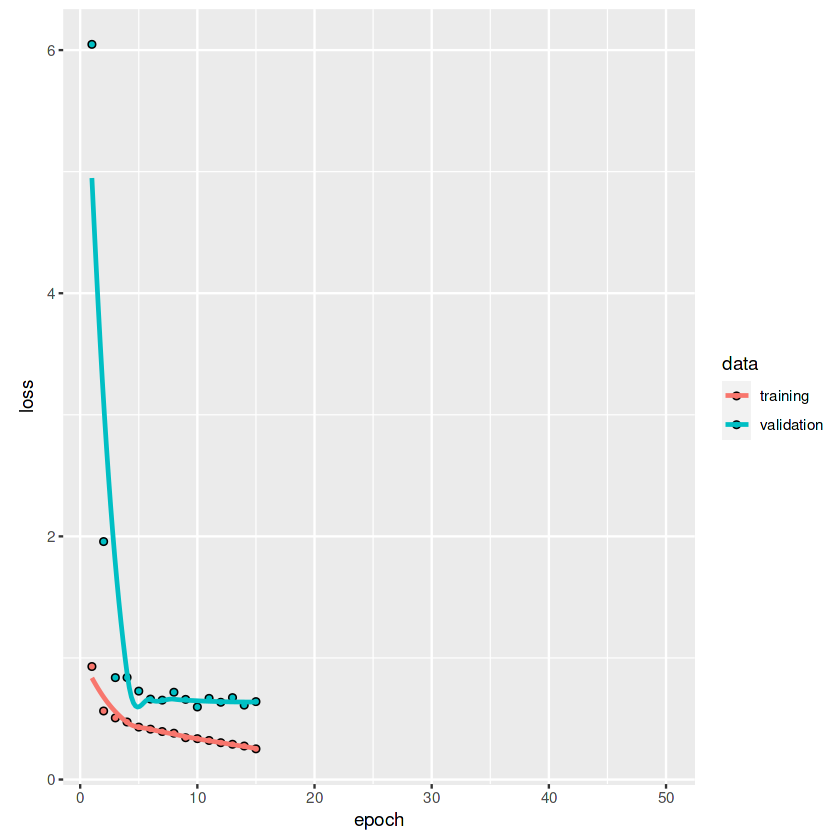

In [20]:
plot(history_deeplab)

In [21]:
save_model_hdf5(deeplab_model, filepath = "/kaggle/working/deeplab_model.h5", include_optimizer = FALSE) # bo chce tylko architekture

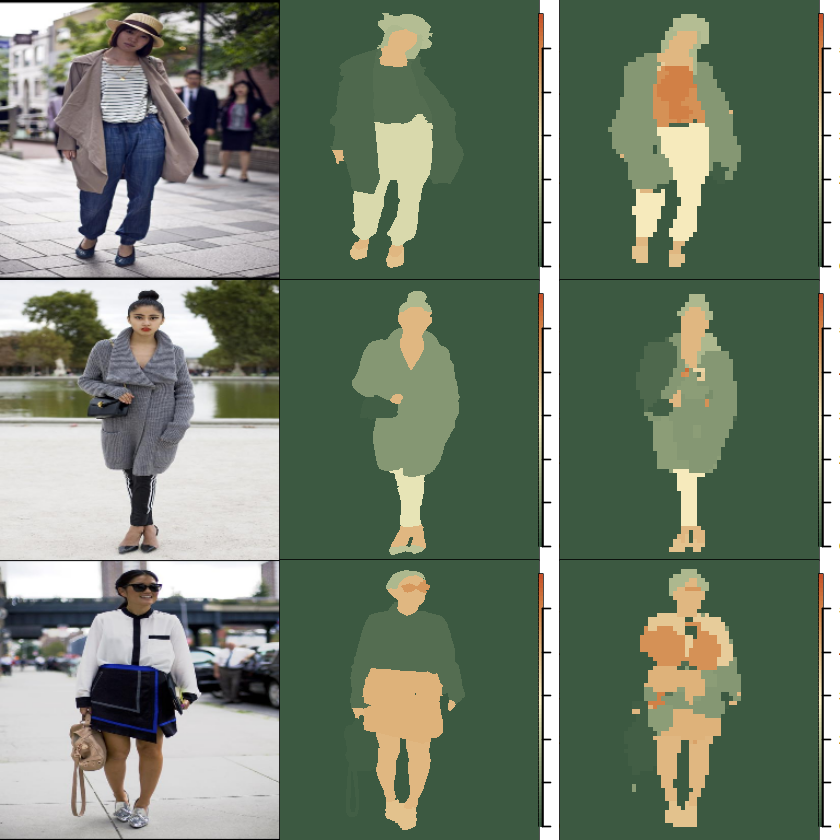

In [22]:
par(mfrow = c(3, 3))
test_image <- vali_paths$input[10] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- vali_paths$mask[10] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  deeplab_model(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

####################################
test_image <- vali_paths$input[21] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- vali_paths$mask[21] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  deeplab_model(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

###################################
test_image <- vali_paths$input[57] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- vali_paths$mask[57] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  deeplab_model(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)


display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

In [23]:
# klasy dla ostatniego obrazka
test_mask %>% as.vector() %>% unique()
predicted_target %>% as.vector() %>% unique()

[1]  0  2  5 41 42 39 19 47

[1]  0  2 41 14 48 42 13 38 51  6 39 19  3  5 47 37 45

Skuteczność modelu daje wiele do życzenia. Niestety również myli klasy obiektów i gorzej wykrywa kontury.

# U-net
Unet jest modelem sieci neuronowej, który został zaproponowany w 2015 roku przez badaczy z Uniwersytetu Johanna Goethego we Frankfurcie. Jest to popularna architektura stosowana w dziedzinie segmentacji obrazu, szczególnie w przypadkach, gdy dostępne są ograniczone zbiory danych treningowych.

Architektura Unet jest symetryczna i składa się z dwóch głównych części: ścieżki kodera (encoder) i ścieżki dekodera (decoder). Ścieżka kodera przypomina typową sieć konwolucyjną, która służy do ekstrakcji cech i redukcji wymiarowości obrazu. Składa się z wielu warstw konwolucyjnych, które sukcesywnie zmniejszają rozdzielczość przestrzenną obrazu, ale zwiększają liczbę cech.

Ścieżka dekodera składa się z warstw dekonwolucyjnych (transposed convolution), które stopniowo zwiększają rozdzielczość obrazu, przywracając go do oryginalnych rozmiarów. W każdym kroku dekodera dane z poprzedniej warstwy dekonwolucyjnej są łączone (concatenated) z odpowiadającymi im danymi z warstwy kodera. Ta operacja pozwala na połączenie lokalnych informacji o cechach ze ścieżki kodera z informacjami o kontekście przestrzennym, co pomaga w dokładniejszej segmentacji.

Dodatkowo, w Unet często wykorzystuje się warstwy zwane "skip connections" (połączenia pomijające). Są to połączenia między warstwami kodera a dekodera, które umożliwiają bezpośredni przepływ informacji o cechach z niższych warstw do wyższych warstw dekodera. To pomaga w zachowaniu szczegółów na różnych poziomach rozdzielczości i ułatwia modelowi nauczenie się lokalnych i globalnych cech jednocześnie.

Unet został szeroko zastosowany w wielu zastosowaniach segmentacji obrazu, w tym w dziedzinach medycyny, biologii, analizy obrazów satelitarnych i wielu innych. Dzięki swojej architekturze, która uwzględnia zarówno lokalne jak i globalne informacje, Unet jest często wybieranym modelem dla zadań segmentacji obrazu, zwłaszcza gdy dostępne są ograniczone zbiory danych treningowych.

In [24]:
conv_block <- function(inputs,
                              num_filters=64,
                              kernel_size=3,
                              dilation_rate=1,
                              padding="same",
                              use_bias=TRUE){
  x <- inputs %>% layer_conv_2d(num_filters, 
                     kernel_size = kernel_size,
                                activation = "relu",
                    dilation_rate = dilation_rate,
                    use_bias = use_bias,
                    kernel_initializer = initializer_he_normal(), padding = padding)
 x <- x %>% layer_batch_normalization() 
  x = tf$nn$relu(x)
    
    x <- x %>% layer_conv_2d(num_filters, 
                     kernel_size = kernel_size,
                             activation = "relu",
                    dilation_rate = dilation_rate,
                    use_bias = use_bias,
                    kernel_initializer = initializer_he_normal(), padding = padding)
    
 x <- x %>% layer_batch_normalization() 
  x = tf$nn$relu(x)
    x
}

In [25]:
encoder_block = function(inputs, num_filters){
    x = conv_block(inputs, num_filters)
    p = x %>% layer_max_pooling_2d(pool_size = c(2, 2))
    l = list(x, p)
    l
}
decoder_block = function(inputs, skip, num_filters){
    x = inputs %>% layer_conv_2d_transpose(filters = num_filters, kernel_size = c(2, 2), strides = 2, padding = "same")
    x = layer_concatenate(inputs = list(x, skip), trainable = TRUE)
    x = x %>% conv_block(num_filters)
    x
}

build_unet = function(input_shape, num_classes){
    inputs = layer_input(shape = input_shape)
    l0 = encoder_block(inputs, num_filters = 32)
    l1 = encoder_block(l0[[2]], num_filters = 64)
    l2 = encoder_block(l1[[2]], num_filters = 128)
    l3 = encoder_block(l2[[2]], num_filters = 256)
    l4 = encoder_block(l3[[2]], num_filters = 512)
    
    b1 = conv_block(l4[[2]], 1024) # bridge
    d1 = decoder_block(b1, l4[[1]], 512)
    d2 = decoder_block(d1, l3[[1]], 256)
    d3 = decoder_block(d2, l2[[1]], 128)
    d4 = decoder_block(d3, l1[[1]], 64)
    d5 = decoder_block(d4, l0[[1]], 32)
    # output
    output = d5 %>% layer_conv_2d(num_classes,1, padding = "same", activation = "softmax")
    model = keras_model(inputs, output)
    model
}

In [26]:
input_shape = c(256, 256, 3)
unet_mod = build_unet(input_shape, 59)
summary(unet_mod)

Model: "model_1"
________________________________________________________________________________
 Layer (type)             Output Shape      Param #  Connected to               
 input_3 (InputLayer)     [(None, 256, 256  0        []                         
                          , 3)]                                                 
                                                                                
 conv2d_13 (Conv2D)       (None, 256, 256,  896      ['input_3[0][0]']          
                           32)                                                  
                                                                                
 batch_normalization_13 (  (None, 256, 256,  128     ['conv2d_13[0][0]']        
 BatchNormalization)       32)                                                  
                                                                                
 tf.nn.relu_11 (TFOpLambd  (None, 256, 256,  0       ['batch_normalization_13[0]
 a)        

In [27]:
opti = tf$keras$optimizers$Adam(learning_rate = 0.001)
unet_mod %>%
 compile(optimizer = opti,
         loss = "sparse_categorical_crossentropy") 

In [28]:
history_unet <- unet_mod %>% fit(
 train_dataset,
 epochs = 50,
 callbacks = callbacks,
 validation_data = vali_dataset)

`geom_smooth()` using formula = 'y ~ x'


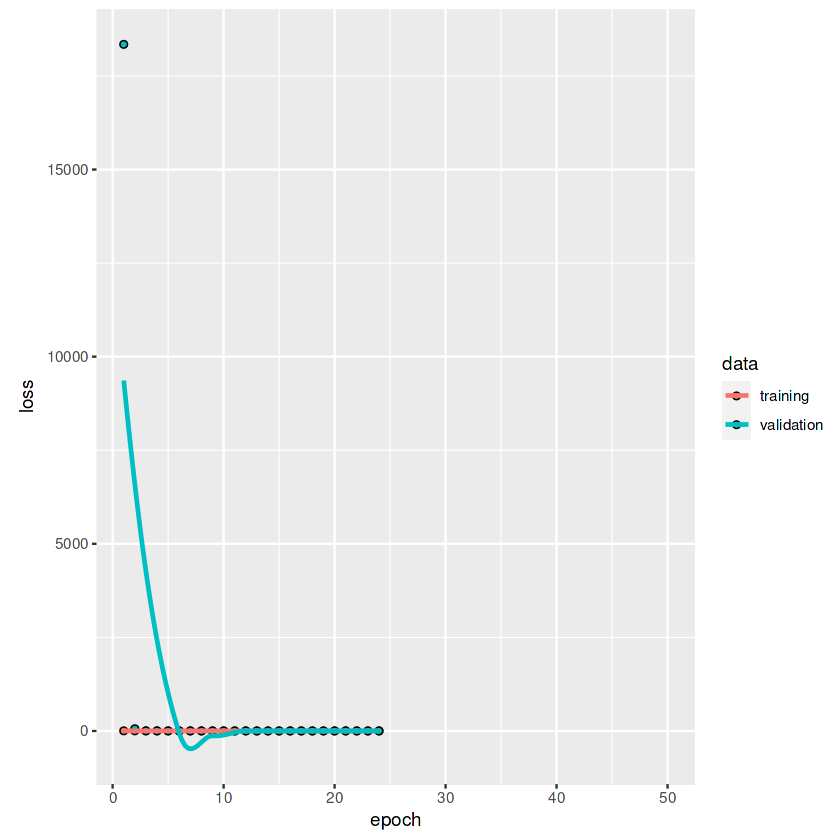

In [29]:
plot(history_unet)


In [30]:
save_model_hdf5(unet_mod, filepath = "/kaggle/working/unet_mod.h5", include_optimizer = FALSE) # bo chce tylko architekture

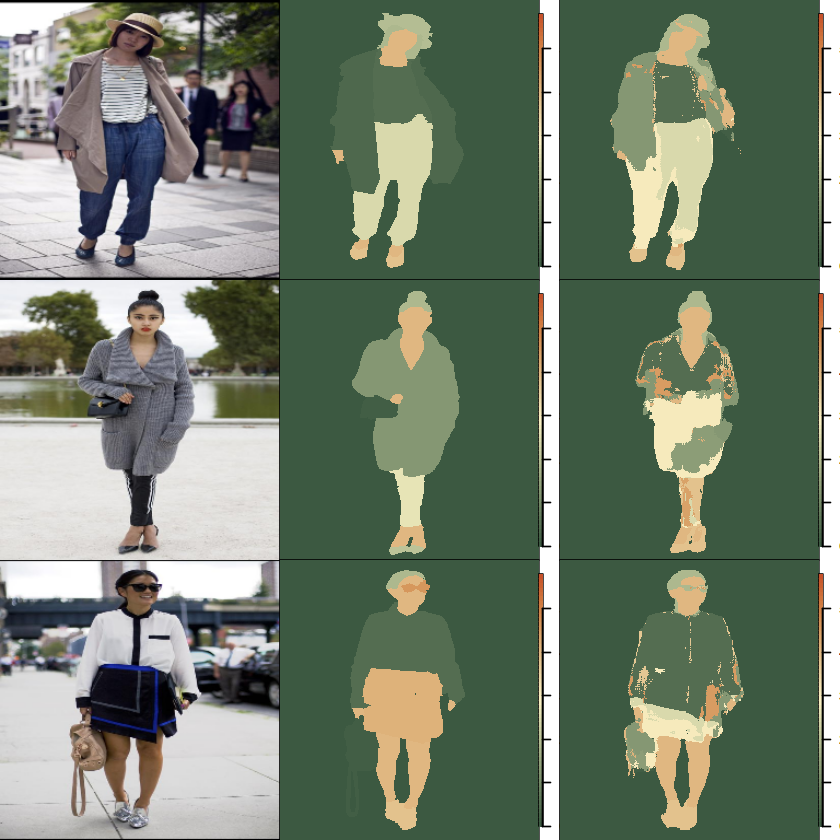

In [31]:
par(mfrow = c(3, 3))
test_image <- vali_paths$input[10] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- vali_paths$mask[10] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  unet_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

####################################
test_image <- vali_paths$input[21] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- vali_paths$mask[21] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  unet_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

###################################
test_image <- vali_paths$input[57] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- vali_paths$mask[57] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  unet_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)


display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

Model najlepiej ze wszystkich zdaje się najlepiej rozpoznawać kształty, ale najgorzej rozpoznaje klasy. Na każdym przykładowym obrazie widoczne są nieuzasadnione artefakty.

# Predykcja modeli na obrazach ze zbioru testowego

Wydajność modelu mierzona tylko funkcją straty może być myląca w obliczu postawionego celu. Wobec tego, w celu oceny możliwości modeli dokonane zostaną predykcje na kilku losowych obrazach.

## Densenet:

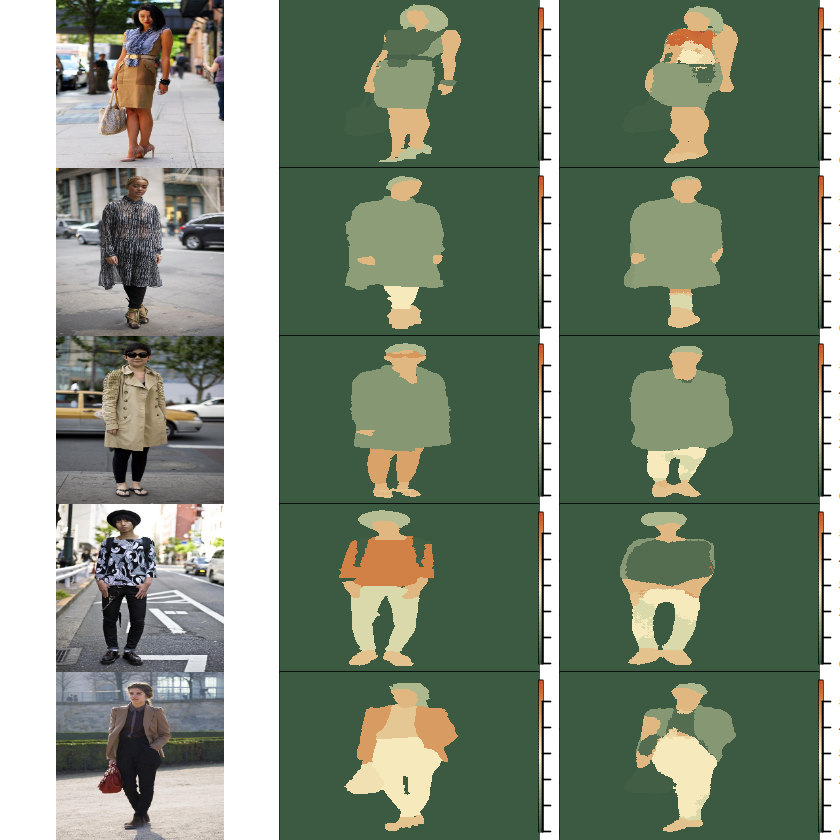

In [32]:
#densenet
par(mfrow = c(5, 3))

test_image <- test_paths$input[10] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[10] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  dense_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

#########################################
test_image <- test_paths$input[17] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[17] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  dense_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

########################

test_image <- test_paths$input[162] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[162] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  dense_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

#####

test_image <- test_paths$input[111] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[111] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  dense_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)


#####

test_image <- test_paths$input[87] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[87] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  dense_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)




## DeepLabV3:

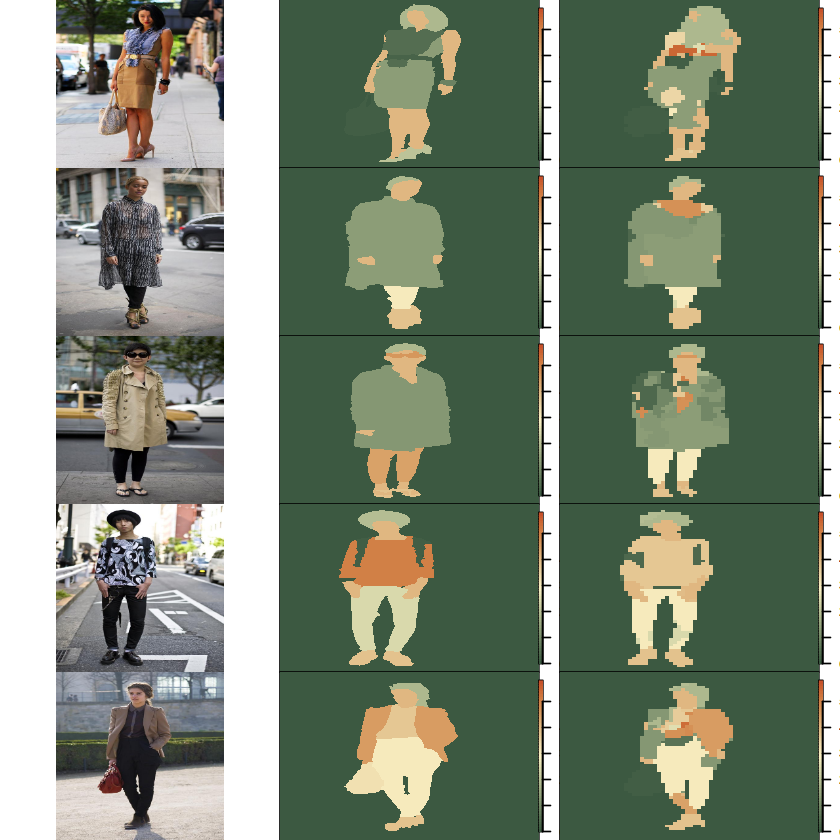

In [33]:
#densenet
par(mfrow = c(5, 3))

test_image <- test_paths$input[10] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[10] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  deeplab_model(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

#########################################
test_image <- test_paths$input[17] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[17] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  deeplab_model(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

########################

test_image <- test_paths$input[162] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[162] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  deeplab_model(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

#####

test_image <- test_paths$input[111] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[111] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  deeplab_model(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)


#####

test_image <- test_paths$input[87] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[87] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  deeplab_model(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)




## U-net

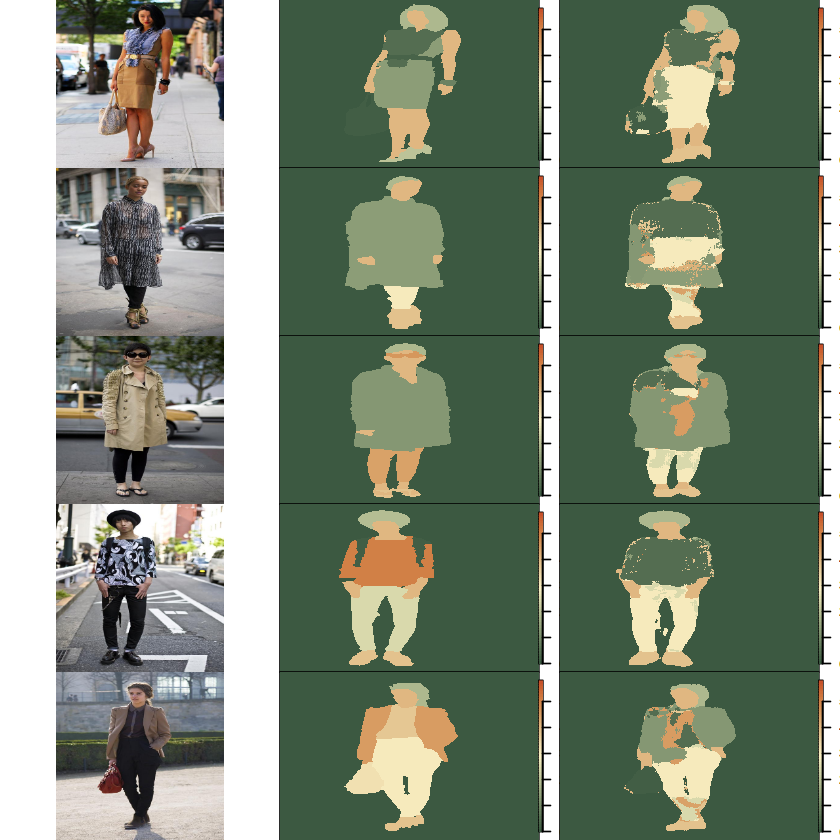

In [34]:
#densenet
par(mfrow = c(5, 3))

test_image <- test_paths$input[10] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[10] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  unet_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

#########################################
test_image <- test_paths$input[17] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[17] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  unet_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

########################

test_image <- test_paths$input[162] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[162] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  unet_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)

#####

test_image <- test_paths$input[111] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[111] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  unet_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)


#####

test_image <- test_paths$input[87] %>%
  tf_read_image_and_resize("png", channels = 3L)

test_mask <- test_paths$mask[87] %>%
   tf$io$read_file() %>%
   tf$io$decode_jpeg()

predicted_mask_probs <- 
  unet_mod(test_image[tf$newaxis, , , ])

predicted_target <- 
  tf$argmax(predicted_mask_probs, axis = -1L)

display_image_tensor(test_image)
display_target_tensor(test_mask)
display_target_tensor(predicted_target)
